Energy threshold: 45.225082804709665, Spread threshold: 2058.355211134268


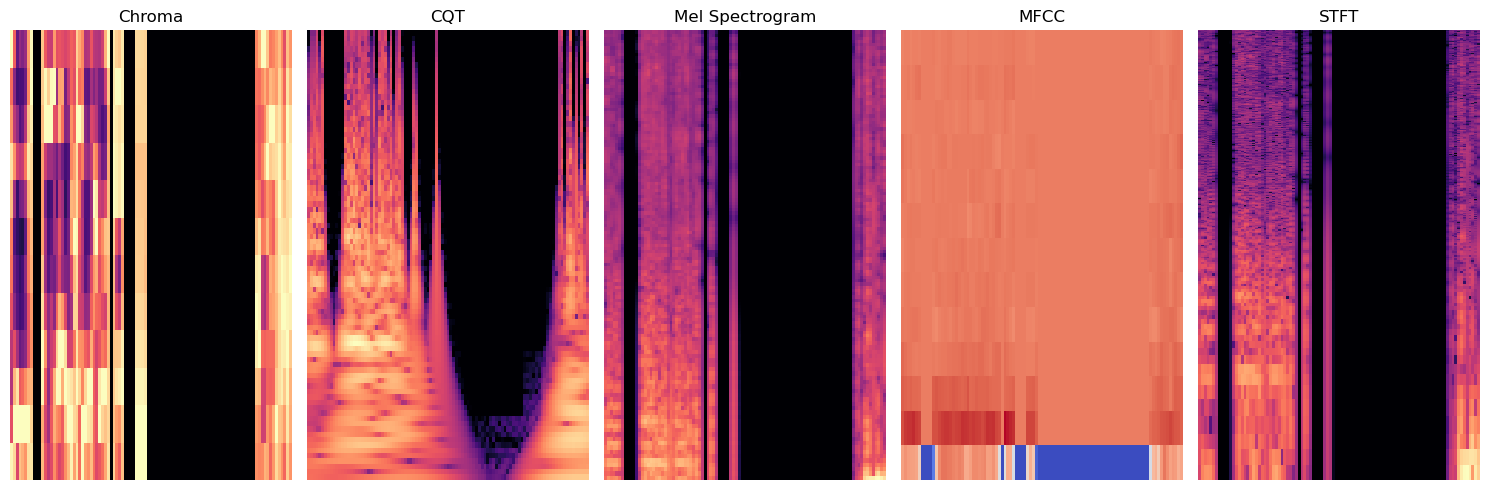

In [30]:
def display_sample_spectrogram(y_segment, sr):
    fig, axes = plt.subplots(1, len(types), figsize=(15, 5))
    for idx, img_type in enumerate(types):
        ax = axes[idx]
        if img_type == 'chroma':
            chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
            librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax)
            ax.set_title('Chroma')
        elif img_type == 'cqt':
            cqt = librosa.amplitude_to_db(np.abs(librosa.cqt(y_segment, sr=sr)), ref=np.max)
            librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
            ax.set_title('CQT')
        elif img_type == 'mel':
            mel = librosa.feature.melspectrogram(y=y_segment, sr=sr)
            librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=sr, x_axis='time', y_axis='mel', ax=ax)
            ax.set_title('Mel Spectrogram')
        elif img_type == 'mfcc':
            mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
            librosa.display.specshow(mfcc, x_axis='time', ax=ax)
            ax.set_title('MFCC')
        elif img_type == 'stft':
            n_fft = min(2048, len(y_segment) // 2)
            stft = librosa.amplitude_to_db(np.abs(librosa.stft(y_segment, n_fft=n_fft)), ref=np.max)
            librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='log', ax=ax)
            ax.set_title('STFT')

        ax.axis('off')  # Remove axes for a cleaner view

    plt.tight_layout()
    plt.show()

# Load an audio file and extract a segment to use as a sample
sample_file = os.path.join(input_base_path, categories[0], os.listdir(os.path.join(input_base_path, categories[0]))[0])
y, sr = librosa.load(sample_file, sr=None)
st_energy, spectral_spread = compute_energy_spread(y, sr)
speech_segments = vad_segmentation(y, sr, st_energy, spectral_spread, threshold_factor)

if speech_segments:
    # Select the first valid segment for visualization
    segment_indices = speech_segments[0]
    start = segment_indices[0] * int(sr * vad_window_size)
    end = segment_indices[-1] * int(sr * vad_window_size)
    y_segment = y[start:end]
    
    display_sample_spectrogram(y_segment, sr)


Energy threshold: 45.225082804709665, Spread threshold: 2058.355211134268


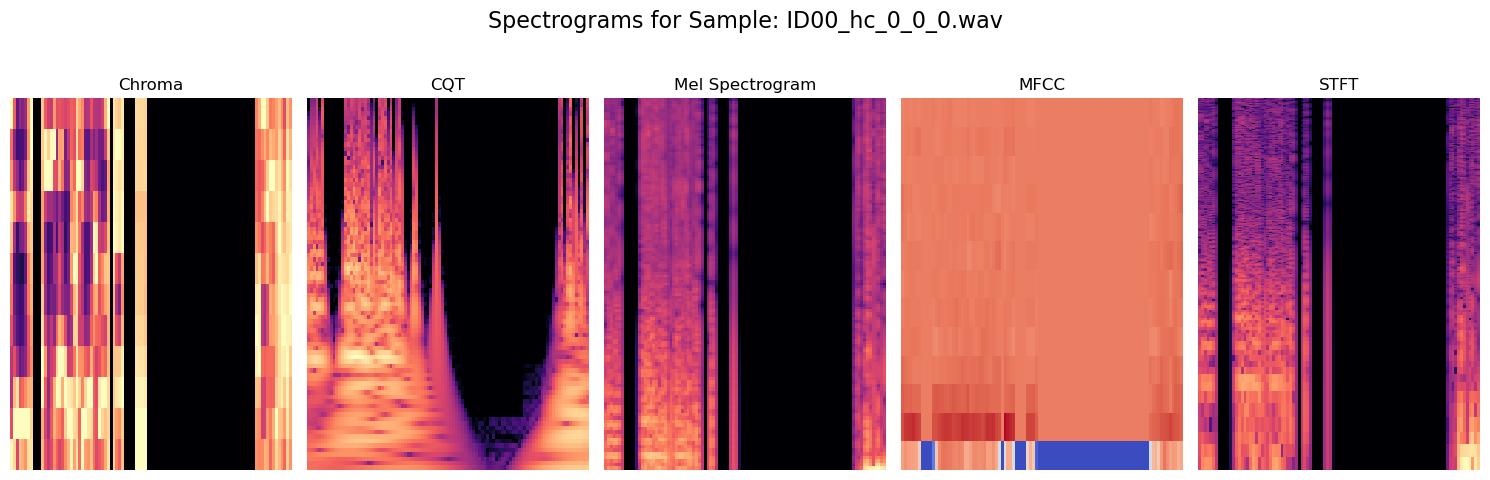

In [31]:
def display_sample_spectrogram(y_segment, sr, sample_name):
    fig, axes = plt.subplots(1, len(types), figsize=(15, 5))
    fig.suptitle(f"Spectrograms for Sample: {sample_name}", fontsize=16)  # Set the main title

    for idx, img_type in enumerate(types):
        ax = axes[idx]
        if img_type == 'chroma':
            chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
            librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax)
            ax.set_title('Chroma')
        elif img_type == 'cqt':
            cqt = librosa.amplitude_to_db(np.abs(librosa.cqt(y_segment, sr=sr)), ref=np.max)
            librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note', ax=ax)
            ax.set_title('CQT')
        elif img_type == 'mel':
            mel = librosa.feature.melspectrogram(y=y_segment, sr=sr)
            librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=sr, x_axis='time', y_axis='mel', ax=ax)
            ax.set_title('Mel Spectrogram')
        elif img_type == 'mfcc':
            mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
            librosa.display.specshow(mfcc, x_axis='time', ax=ax)
            ax.set_title('MFCC')
        elif img_type == 'stft':
            n_fft = min(2048, len(y_segment) // 2)
            stft = librosa.amplitude_to_db(np.abs(librosa.stft(y_segment, n_fft=n_fft)), ref=np.max)
            librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='log', ax=ax)
            ax.set_title('STFT')

        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for the title
    plt.show()

# Load a sample file and display the spectrograms
sample_file = os.path.join(input_base_path, categories[0], os.listdir(os.path.join(input_base_path, categories[0]))[0])
y, sr = librosa.load(sample_file, sr=None)
st_energy, spectral_spread = compute_energy_spread(y, sr)
speech_segments = vad_segmentation(y, sr, st_energy, spectral_spread, threshold_factor)

if speech_segments:
    segment_indices = speech_segments[0]
    start = segment_indices[0] * int(sr * vad_window_size)
    end = segment_indices[-1] * int(sr * vad_window_size)
    y_segment = y[start:end]
    
    display_sample_spectrogram(y_segment, sr, os.path.basename(sample_file))


In [1]:

# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model


Training model for spectrogram type: mfcc
Epoch 1/50
60/60 [==============================] - 261s 4s/step - loss: 0.8171 - accuracy: 0.5746 - val_loss: 0.6684 - val_accuracy: 0.5905
Epoch 2/50
60/60 [==============================] - 259s 4s/step - loss: 0.6800 - accuracy: 0.6116 - val_loss: 0.6631 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 240s 4s/step - loss: 0.6588 - accuracy: 0.6286 - val_loss: 0.6659 - val_accuracy: 0.6000
Epoch 4/50
60/60 [==============================] - 241s 4s/step - loss: 0.6522 - accuracy: 0.6360 - val_loss: 0.6634 - val_accuracy: 0.6000
Epoch 5/50
60/60 [==============================] - 257s 4s/step - loss: 0.6460 - accuracy: 0.6296 - val_loss: 0.6566 - val_accuracy: 0.6286
Epoch 6/50
60/60 [==============================] - 241s 4s/step - loss: 0.6457 - accuracy: 0.6233 - val_loss: 0.6669 - val_accuracy: 0.6095
Epoch 7/50
60/60 [==============================] - 240s 4s/step - loss: 0.6510 - accuracy: 0.6212 - val_loss: 0

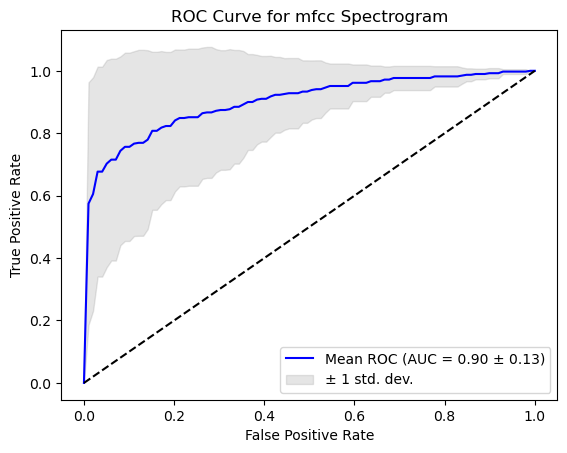


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                    5.500000
Accuracy               86.952381
F1 Score                0.859170
Precision               0.866747
Recall                  0.869524
Specificity             0.934755
Kappa                   0.697933
ROC AUC                 0.901826
Training Time (s)    3965.200564
Testing Time (s)        9.532634
dtype: float64
Fold                    3.027650
Accuracy               13.528802
F1 Score                0.153316
Precision               0.143770
Recall                  0.135288
Specificity             0.052986
Kappa                   0.328262
ROC AUC                 0.132602
Training Time (s)    3569.937724
Testing Time (s)        1.221498
dtype: float64


In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mel
Epoch 1/50
60/60 [==============================] - 163s 3s/step - loss: 0.7534 - accuracy: 0.6011 - val_loss: 0.6612 - val_accuracy: 0.6667
Epoch 2/50
60/60 [==============================] - 158s 3s/step - loss: 0.6433 - accuracy: 0.6169 - val_loss: 0.6200 - val_accuracy: 0.6381
Epoch 3/50
60/60 [==============================] - 155s 3s/step - loss: 0.5922 - accuracy: 0.6889 - val_loss: 0.5763 - val_accuracy: 0.7810
Epoch 4/50
60/60 [==============================] - 152s 3s/step - loss: 0.5199 - accuracy: 0.7587 - val_loss: 0.5164 - val_accuracy: 0.8190
Epoch 5/50
60/60 [==============================] - 153s 3s/step - loss: 0.4450 - accuracy: 0.7958 - val_loss: 0.4784 - val_accuracy: 0.8190
Epoch 6/50
60/60 [==============================] - 154s 3s/step - loss: 0.3712 - accuracy: 0.8381 - val_loss: 0.4962 - val_accuracy: 0.7714
Epoch 7/50
60/60 [==============================] - 154s 3s/step - loss: 0.3142 - accuracy: 0.8646 - val_loss: 0.

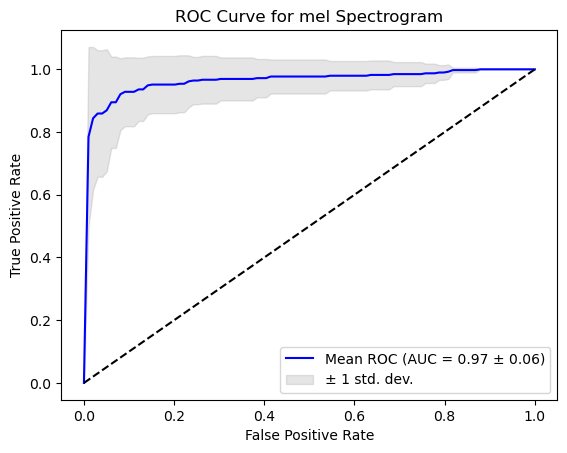


Mean and Std Dev of Performance Metrics for Spectrogram mel:
Fold                    5.500000
Accuracy               94.190476
F1 Score                0.940812
Precision               0.941954
Recall                  0.941905
Specificity             0.971212
Kappa                   0.871790
ROC AUC                 0.966239
Training Time (s)    2756.165287
Testing Time (s)        4.501084
dtype: float64
Fold                    3.027650
Accuracy                7.424093
F1 Score                0.075859
Precision               0.074307
Recall                  0.074241
Specificity             0.037421
Kappa                   0.164541
ROC AUC                 0.060322
Training Time (s)    2382.386474
Testing Time (s)        0.178315
dtype: float64


In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: mfcc
Epoch 1/50
60/60 [==============================] - 310s 5s/step - loss: 0.8148 - accuracy: 0.5704 - val_loss: 0.7094 - val_accuracy: 0.6286
Epoch 2/50
60/60 [==============================] - 300s 5s/step - loss: 0.6806 - accuracy: 0.5937 - val_loss: 0.6591 - val_accuracy: 0.6286
Epoch 3/50
60/60 [==============================] - 254s 4s/step - loss: 0.6747 - accuracy: 0.6190 - val_loss: 0.7188 - val_accuracy: 0.3619
Epoch 4/50
60/60 [==============================] - 168s 3s/step - loss: 0.6819 - accuracy: 0.5937 - val_loss: 0.6558 - val_accuracy: 0.6381
Epoch 5/50
60/60 [==============================] - 164s 3s/step - loss: 0.6548 - accuracy: 0.6275 - val_loss: 0.6485 - val_accuracy: 0.6286
Epoch 6/50
60/60 [==============================] - 171s 3s/step - loss: 0.6422 - accuracy: 0.6392 - val_loss: 0.6626 - val_accuracy: 0.6286
Epoch 7/50
60/60 [==============================] - 157s 3s/step - loss: 0.6418 - accuracy: 0.6466 - val_loss: 0

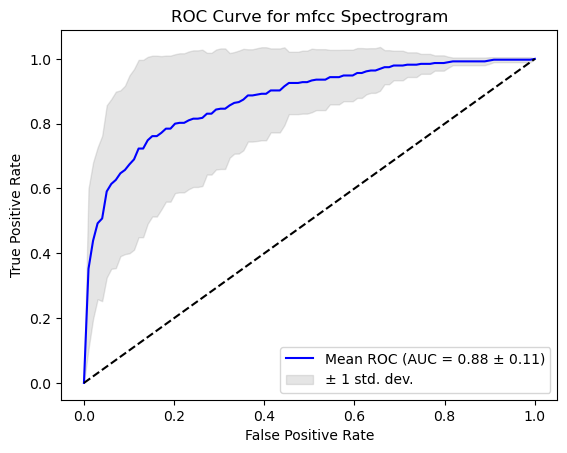


Mean and Std Dev of Performance Metrics for Spectrogram mfcc:
Fold                    5.500000
Accuracy               81.904762
F1 Score                0.805145
Precision               0.827310
Recall                  0.819048
Specificity             0.920886
Kappa                   0.584661
ROC AUC                 0.876615
Training Time (s)    1907.313118
Testing Time (s)        5.778178
dtype: float64
Fold                    3.027650
Accuracy                9.836148
F1 Score                0.119687
Precision               0.094194
Recall                  0.098361
Specificity             0.065855
Kappa                   0.247437
ROC AUC                 0.118178
Training Time (s)    1459.618668
Testing Time (s)        0.401892
dtype: float64


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: stft
Epoch 1/50
60/60 [==============================] - 144s 2s/step - loss: 0.7724 - accuracy: 0.5979 - val_loss: 0.5341 - val_accuracy: 0.7714
Epoch 2/50
60/60 [==============================] - 145s 2s/step - loss: 0.4665 - accuracy: 0.7905 - val_loss: 0.5074 - val_accuracy: 0.7905
Epoch 3/50
60/60 [==============================] - 145s 2s/step - loss: 0.4215 - accuracy: 0.8074 - val_loss: 0.4857 - val_accuracy: 0.8000
Epoch 4/50
60/60 [==============================] - 146s 2s/step - loss: 0.3743 - accuracy: 0.8307 - val_loss: 0.4820 - val_accuracy: 0.8095
Epoch 5/50
60/60 [==============================] - 146s 2s/step - loss: 0.3300 - accuracy: 0.8529 - val_loss: 0.4680 - val_accuracy: 0.8095
Epoch 6/50
60/60 [==============================] - 146s 2s/step - loss: 0.2925 - accuracy: 0.8709 - val_loss: 0.4972 - val_accuracy: 0.8095
Epoch 7/50
60/60 [==============================] - 146s 2s/step - loss: 0.2358 - accuracy: 0.9016 - val_loss: 0

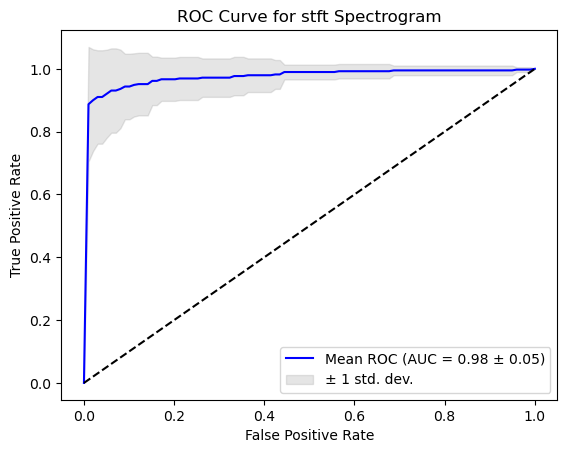


Mean and Std Dev of Performance Metrics for Spectrogram stft:
Fold                    5.500000
Accuracy               95.904762
F1 Score                0.957531
Precision               0.960709
Recall                  0.959048
Specificity             0.987879
Kappa                   0.907821
ROC AUC                 0.977545
Training Time (s)    2718.810007
Testing Time (s)        4.872268
dtype: float64
Fold                    3.027650
Accuracy                6.599052
F1 Score                0.069287
Precision               0.062631
Recall                  0.065991
Specificity             0.019948
Kappa                   0.150685
ROC AUC                 0.048183
Training Time (s)    1692.055084
Testing Time (s)        1.043153
dtype: float64


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: cqt
Epoch 1/50
60/60 [==============================] - 280s 5s/step - loss: 0.6900 - accuracy: 0.5968 - val_loss: 0.5043 - val_accuracy: 0.8286
Epoch 2/50
60/60 [==============================] - 278s 5s/step - loss: 0.4635 - accuracy: 0.7947 - val_loss: 0.4771 - val_accuracy: 0.7905
Epoch 3/50
60/60 [==============================] - 277s 5s/step - loss: 0.3692 - accuracy: 0.8328 - val_loss: 0.4989 - val_accuracy: 0.8000
Epoch 4/50
60/60 [==============================] - 221s 4s/step - loss: 0.3140 - accuracy: 0.8730 - val_loss: 0.5212 - val_accuracy: 0.7714
Epoch 5/50
60/60 [==============================] - 261s 4s/step - loss: 0.2429 - accuracy: 0.9111 - val_loss: 0.5784 - val_accuracy: 0.8000
Epoch 6/50
60/60 [==============================] - 260s 4s/step - loss: 0.1871 - accuracy: 0.9450 - val_loss: 0.5522 - val_accuracy: 0.8000
Epoch 7/50
60/60 [==============================] - 250s 4s/step - loss: 0.1394 - accuracy: 0.9545 - val_loss: 0.

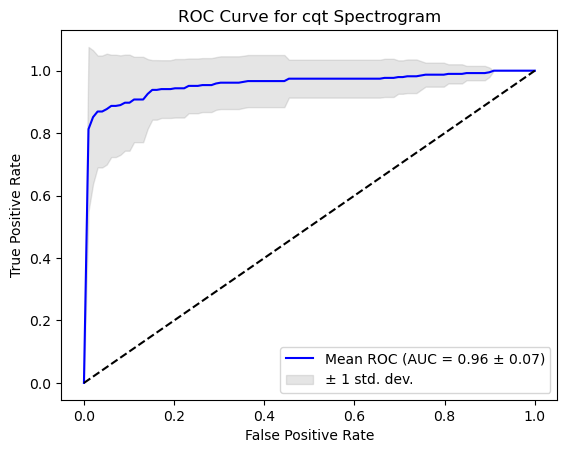


Mean and Std Dev of Performance Metrics for Spectrogram cqt:
Fold                     5.500000
Accuracy                93.904762
F1 Score                 0.937396
Precision                0.939009
Recall                   0.939048
Specificity              0.969697
Kappa                    0.864171
ROC AUC                  0.960256
Training Time (s)    12325.359733
Testing Time (s)         7.035001
dtype: float64
Fold                     3.027650
Accuracy                 8.754080
F1 Score                 0.090390
Precision                0.087527
Recall                   0.087541
Specificity              0.041030
Kappa                    0.196502
ROC AUC                  0.072357
Training Time (s)    17403.999943
Testing Time (s)         1.091261
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


Training model for spectrogram type: chroma
Epoch 1/50
60/60 [==============================] - 272s 5s/step - loss: 0.6204 - accuracy: 0.6550 - val_loss: 0.5466 - val_accuracy: 0.7429
Epoch 2/50
60/60 [==============================] - 270s 5s/step - loss: 0.5060 - accuracy: 0.7630 - val_loss: 0.5929 - val_accuracy: 0.6762
Epoch 3/50
60/60 [==============================] - 279s 5s/step - loss: 0.4283 - accuracy: 0.8042 - val_loss: 0.5556 - val_accuracy: 0.7524
Epoch 4/50
60/60 [==============================] - 288s 5s/step - loss: 0.3309 - accuracy: 0.8582 - val_loss: 0.6034 - val_accuracy: 0.6762
Epoch 5/50
60/60 [==============================] - 283s 5s/step - loss: 0.2022 - accuracy: 0.9259 - val_loss: 0.7514 - val_accuracy: 0.7238
Epoch 6/50
60/60 [==============================] - 282s 5s/step - loss: 0.0999 - accuracy: 0.9725 - val_loss: 0.9995 - val_accuracy: 0.6952
Fold 1 Results: Accuracy=74.29%, F1=0.72, Precision=0.76, Recall=0.74, Specificity=0.94, Kappa=0.39, ROC AUC=0

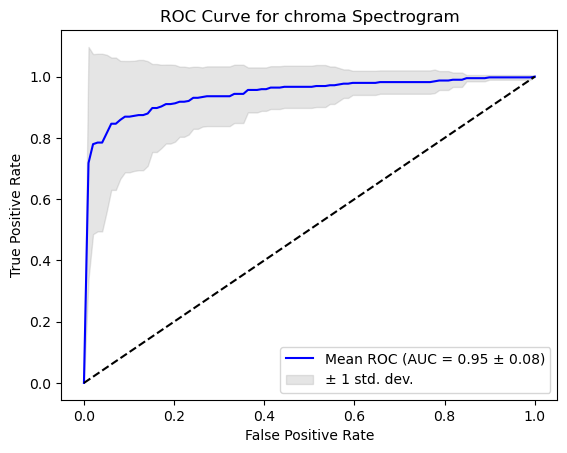


Mean and Std Dev of Performance Metrics for Spectrogram chroma:
Fold                    5.500000
Accuracy               92.095238
F1 Score                0.917680
Precision               0.923893
Recall                  0.920952
Specificity             0.965152
Kappa                   0.822502
ROC AUC                 0.945882
Training Time (s)    6305.563344
Testing Time (s)        8.167126
dtype: float64
Fold                    3.027650
Accuracy                9.989160
F1 Score                0.105409
Precision               0.096185
Recall                  0.099892
Specificity             0.061876
Kappa                   0.227267
ROC AUC                 0.083793
Training Time (s)    6658.465533
Testing Time (s)        3.200784
dtype: float64


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU, Multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels


# Define the PSFAN model function
def PSFAN(input, num_classes):
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    input_layer = Input(shape=input_shape, name='input')
    model = PSFAN(input_layer, num_classes)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kfold.split(x, y), 1):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)

        model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Record training time
        start_train = time.time()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
        training_time = time.time() - start_train

        # Record testing time
        start_test = time.time()
        y_pred_prob = model.predict(X_test)
        testing_time = time.time() - start_test

        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_true) * 100
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        kappa = cohen_kappa_score(y_true, y_pred)

        # Specificity calculation
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)

        fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)

        fold_metrics.append({
            "Fold": fold,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "Kappa": kappa,
            "ROC AUC": roc_auc,
            "Training Time (s)": training_time,
            "Testing Time (s)": testing_time
        })

        print(f"Fold {fold} Results: Accuracy={accuracy:.2f}%, F1={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, Specificity={specificity:.2f}, Kappa={kappa:.2f}, ROC AUC={roc_auc:.2f}")
        
    # Plot ROC Curve with mean and std deviation
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)

    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display mean and std dev of other metrics
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()

    print(f"\nMean and Std Dev of Performance Metrics for Spectrogram {spectrogram}:")
    print(mean_metrics)
    print(std_metrics)


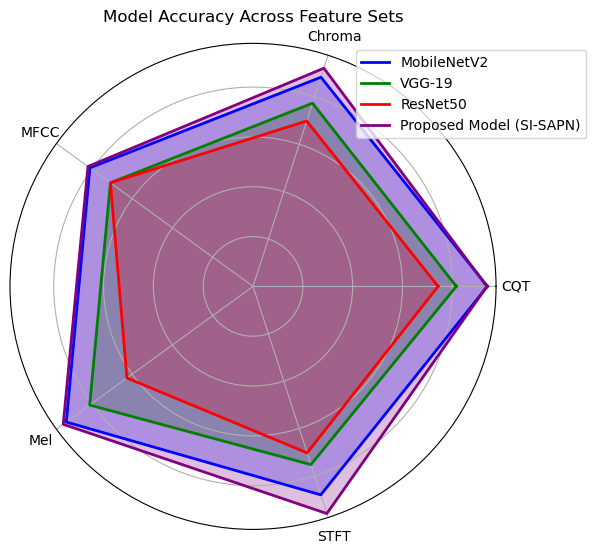

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Data
labels = ['CQT', 'Chroma', 'MFCC', 'Mel', 'STFT']
mobile_net_v2 = [94.09, 88.29, 80.95, 92.67, 88.00]
vgg_19 = [81.62, 77.33, 70.76, 81.05, 75.24]
resnet_50 = [74.29, 69.81, 70.76, 62.57, 70.29]
proposed_model = [93.90, 92.10, 81.90, 94.19, 95.90]

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot
mobile_net_v2 += mobile_net_v2[:1]
vgg_19 += vgg_19[:1]
resnet_50 += resnet_50[:1]
proposed_model += proposed_model[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw=dict(polar=True))

# Plot each model
ax.plot(angles, mobile_net_v2, color='blue', linewidth=2, label='MobileNetV2')
ax.fill(angles, mobile_net_v2, color='blue', alpha=0.25)

ax.plot(angles, vgg_19, color='green', linewidth=2, label='VGG-19')
ax.fill(angles, vgg_19, color='green', alpha=0.25)

ax.plot(angles, resnet_50, color='red', linewidth=2, label='ResNet50')
ax.fill(angles, resnet_50, color='red', alpha=0.25)

ax.plot(angles, proposed_model, color='purple', linewidth=2, label='Proposed Model (SI-SAPN)')
ax.fill(angles, proposed_model, color='purple', alpha=0.25)

# Labels and title
ax.set_yticklabels([])  # Hide radial axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Model Accuracy Across Feature Sets')

# Legend
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

plt.tight_layout()
plt.show()
